In [78]:
# install all needed packages
from typing import Tuple
import numpy as np
import os
import random
import skimage
from skimage import transform
import skimage.data
import skimage.io
import tensorflow.keras as keras

# for displaying images in jupyter
from matplotlib import pyplot as plt

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

ModuleNotFoundError: No module named 'sklearn'

### Random images


In [2]:
def gen_random_binary_test_image_classes(height: int, width: int, nr_classes)->(np.ndarray, np.ndarray):
    """
    Generate a test image and an appropriate label image with label 0 or label 1
    Label 0 images have a lower medium grayscale value, label 1 images a higher one.
    
    The returned images will have shape (height, width, 1) and type uint8 to be as compatible as possible to 
    mages read from files
    """ 
    class_id = np.random.choice(range(nr_classes))
    value = 255.0 * class_id / nr_classes 
    
    NOISE = 20.0
    
    label = np.zeros((height, width, 1), dtype=np.uint8)
    label.fill(class_id)
    img = np.random.normal(value, NOISE, ((height, width, 1))).astype(np.uint8)
    
    return img, label

def gen_batch_binary_with_border(batch_size, height: int, width: int, border: int, nr_classes:int):
    image_list = []
    label_list = []
    for i in range(batch_size):
        img, label = gen_random_binary_test_image_classes(height=height, width=width, nr_classes=nr_classes)
        if(border > 0):
            label = label[border:-border, border:-border]
        image_list.append(img.astype(np.float32) / 255.0)
        label_list.append(label.astype(np.float32))

    image_batch = np.array(image_list, dtype=np.float32)
    label_batch = np.array(label_list, dtype=np.float32)

    # reshape labels as this is not done in the model
    label_batch = label_batch.reshape(batch_size, (height-2*border)*(width-2*border), 1)
    label_batch = keras.utils.to_categorical(label_batch, num_classes=nr_classes)

    return image_batch, label_batch

def batch_generator_with_border(batch_size, height: int, width: int, border: int, nr_classes:int):
    while True:
        image_batch, label_batch = gen_batch_binary_with_border(batch_size=batch_size, 
                                                                height=height, width=width, 
                                                                border=border, nr_classes=nr_classes)
        yield image_batch, label_batch

In [3]:
image_batch, label_batch = gen_batch_binary_with_border(100, 128, 128, 3, 42)

### Data Loading from dtd

In [4]:
NUM_CLASSES_DTD = 42

In [147]:
def load_image(folder, imgIdx: int, height: int, width: int):
    imgPath = os.path.join(folder, "image_{:05d}.png".format(imgIdx))
    labelPath = os.path.join(folder, "label_{:05d}.png".format(imgIdx))
    
    img = skimage.io.imread(imgPath, as_gray=True)
    img =  transform.resize(img, (height, width), anti_aliasing=True).reshape((height, width,1))
    img = (img - img.mean()) 
    img = img / np.sqrt(img.var())
    label = skimage.io.imread(labelPath, as_gray=True)
    label =  transform.resize(label, (height, width), anti_aliasing=True).reshape((height, width,1))
    return img, label

def load_image2(folder, imgIdx: int, height: int, width: int):
    imgPath = os.path.join(folder, "image_{:05d}.png".format(imgIdx))
    labelPath = os.path.join(folder, "label_{:05d}.png".format(imgIdx))
    
    img = skimage.io.imread(imgPath, as_gray=True)
    img =  transform.resize(img, (height, width), anti_aliasing=True).reshape((height, width,1))
    label = skimage.io.imread(labelPath, as_gray=True)
    label =  transform.resize(label, (height, width), anti_aliasing=True)[0, 0]
    return img, label

In [148]:
def load_batch(folder, nr_classes, indices, height: int, width: int, border:int):
    image_list = []
    label_list = []
    for i in indices:
        img, lbl = load_image(folder, i, height, width)
        if(border > 0):
            lbl = lbl[border:-border, border:-border]
        image_list.append(img)
        label_list.append(lbl)
    
    image_batch = np.array(image_list, dtype=np.float32)
    label_batch = np.array(label_list, dtype=np.float32)

    # reshape labels as this is not done in the model
    label_batch = label_batch.reshape(len(indices), (height-2*border)*(width-2*border), 1)*255
    label_batch = keras.utils.to_categorical(label_batch, num_classes=nr_classes)
    return image_batch, label_batch

def load_batch2(folder, indices, height: int, width: int):
    image_list = []
    label_list = []
    for i in indices:
        img, lbl = load_image2(folder, i, height, width)
        image_list.append(img)
        label_list.append(lbl)
    
    image_batch = np.array(image_list, dtype=np.float32)
    label_batch = np.array(label_list, dtype=np.float32)
    
    return image_batch, label_batch

In [149]:
def load_batch_random_images_generator(batch_size, folder, nr_classes, height: int, width: int, border:int):
    indices = list(range(0, 1840))
    random.shuffle(indices)
    i = 0
    while True:
        ind = indices[i:i+batch_size]
        image_batch, label_batch = load_batch(folder, nr_classes, ind, height=height, width=width, border=border)
        i = i + batch_size
        i = i % len(indices)
        yield image_batch, label_batch

def load_batch_random_images_generator2(batch_size, folder, height: int, width: int):
    indices = list(range(0, 1840))
    random.shuffle(indices)
    i = 0
    while True:
        ind = indices[i:i+batch_size]
        image_batch, label_batch = load_batch2(folder, ind, height=height, width=width)
        i = i + batch_size
        i = i % len(indices)
        yield image_batch, label_batch

### data

In [6]:
num_classes=48

### Simple FCN

In [143]:
def fcn_simple_border(input_height:int, input_width:int, nr_classes:int) -> (keras.Model, int):
    """
    Create a simple fcn model for semantic segmentation with 2 classes.
    Return both the model and the border size
    """
    model = keras.Sequential()
    border = 0;
    
    # we use grayscale (1-channel input)
    
    # (used to define input shape on the first layers)
    model.add(keras.layers.Layer(input_shape=(input_height , input_width, 1)))
    
    # add 3 convolutional layers with 3x3 filters
    model.add(keras.layers.Convolution2D(filters=4, kernel_size=3, padding='valid', activation='relu'))
    border = border + 1
    model.add(keras.layers.Convolution2D(filters=8, kernel_size=3, padding='valid', activation='relu'))
    border = border + 1
    model.add(keras.layers.Convolution2D(filters=4, kernel_size=3, padding='valid', activation='relu'))
    border = border + 1
    
    # go to logits which is the number of classes and add sigmoid layer for activation
    model.add(keras.layers.Convolution2D(filters=nr_classes, kernel_size=1, activation=None, 
                                         kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.001, seed=None)))
    model.add(keras.layers.Activation('softmax'))
    
    # reshape so that we have a sample for each pixel
    model.add(keras.layers.Reshape(target_shape=((input_height-2*border) * (input_width-2*border), nr_classes)))
    
    return model, border

### Real Data

In [164]:
def fcn_more_comlex_border(input_height:int, input_width:int, nr_classes:int) -> (keras.Model, int):
    border = 0;
    # we use grayscale (1-channel input)
    
    # (used to define input shape on the first layers)
    model = keras.Sequential()
    model.add(keras.layers.Layer(input_shape=(input_height , input_width, 1)))
    

    model.add(keras.layers.Convolution2D(filters=8, kernel_size=3, use_bias=True, padding='same', activation='relu'))
    model.add(keras.layers.Convolution2D(filters=8, kernel_size=3, use_bias=True, padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(strides=2, padding='same')) 
    
    model.add(keras.layers.Convolution2D(filters=8, kernel_size=3, use_bias=True, padding='same', activation='relu'))
    model.add(keras.layers.Convolution2D(filters=8, kernel_size=3, use_bias=True, padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(strides=2, padding='same'))
    
    model.add(keras.layers.Convolution2D(filters=8, kernel_size=3, use_bias=True, padding='same', activation='relu'))
    model.add(keras.layers.Convolution2D(filters=8, kernel_size=3, use_bias=True, padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(strides=2, padding='same')) 
    
    # go to logits which is the number of classes and add sigmoid layer for activation
    model.add(keras.layers.Convolution2D(filters=nr_classes, kernel_size=1, activation=None, 
                                         kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.001, seed=None)))
    model.add(keras.layers.UpSampling2D(size=(8, 8), data_format=None, interpolation='nearest'))
    model.add(keras.layers.Activation('softmax'))
    
    # reshape so that we have a sample for each pixel
    model.add(keras.layers.Reshape(target_shape=((input_height-2*border) * (input_width-2*border), nr_classes)))
    
    return model, border

In [165]:
PATCH_HEIGHT = 128
PATCH_WIDTH = 128
BATCH_SIZE = 80
EPOCHS = 20
STEPS_PER_EPOCHS = 20
NR_CLASSES = 48
model, border = fcn_more_comlex_border(PATCH_HEIGHT, PATCH_WIDTH, NR_CLASSES)
model.summary()
model.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(
        generator=load_batch_random_images_generator(BATCH_SIZE, "dtd_train", NR_CLASSES, PATCH_HEIGHT, PATCH_WIDTH, border),
        epochs=EPOCHS,
        verbose=1,
        steps_per_epoch=STEPS_PER_EPOCHS,
        shuffle=False,
        callbacks=None)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_42 (Layer)             (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_208 (Conv2D)          (None, 128, 128, 8)       80        
_________________________________________________________________
conv2d_209 (Conv2D)          (None, 128, 128, 8)       584       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_210 (Conv2D)          (None, 64, 64, 12)        876       
_________________________________________________________________
conv2d_211 (Conv2D)          (None, 64, 64, 12)        1308      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 32, 32, 12)        0         
__________

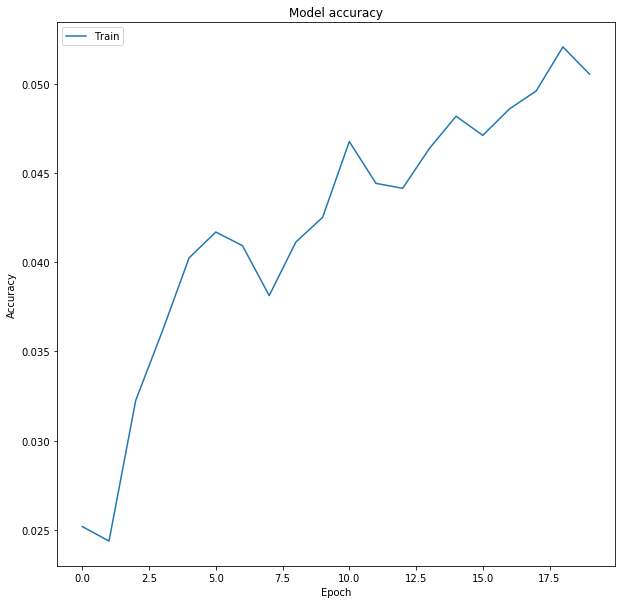

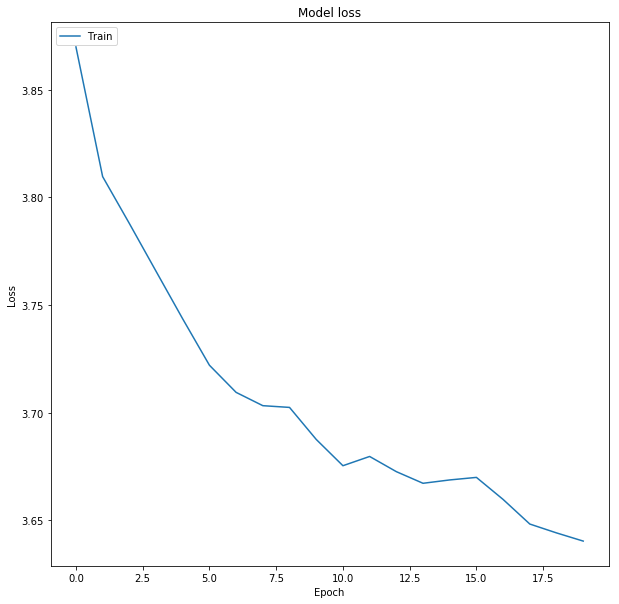

In [167]:
# Plot training accuracy values
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plot training loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [49]:
scores = model.evaluate_generator(
    generator=load_batch_random_images_generator(184, "dtd_test", NR_CLASSES, PATCH_HEIGHT, PATCH_WIDTH, border),
    steps=10)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 97.83%


acc: 97.83%


array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 12., 13., 14.,
       15., 16., 17., 18., 19., 20., 21., 23., 24., 25., 26., 27., 28.,
       30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
       43., 45., 46.], dtype=float32)

In [98]:
gen_batch_binary_with_border(batch_size, height: int, width: int, border: int, nr_classes:int):

1.0

In [107]:
bla, label = load_image("dtd_train", 2, 16,16)

In [107]:
bla = load_batch_random_images_generator(184, "dtd_train", 48, PATCH_HEIGHT, PATCH_WIDTH, border)

In [108]:
imgs, labels = next(bla)

In [109]:
labels[0,10]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [115]:
imgs[2,0,0,0]

-6.4064436

In [111]:
img = imgs[2]

In [114]:
img.var()


51.97912

In [113]:
isinstance(bla, list)

False

In [122]:


imgPath = os.path.join("dtd_train", "image_{:05d}.png".format(2))

img = skimage.io.imread(imgPath, as_gray=True)
img =  transform.resize(img, (128, 128), anti_aliasing=True).reshape((128, 128,1))
img = (img - img.mean()) 
print(img.min(), img.max(), img.var())

-0.37730665019913934 0.41877178117340685 0.035050713205133255


In [121]:
bla = [32, 0.3, 0.111, -.03, -9,3]

In [77]:
np.array(bla, dtype=np.float32)

array([ 3.20e+01,  3.00e-01,  1.11e-01, -3.00e-02, -9.00e+00,  3.00e+00],
      dtype=float32)